# **PARAMS**


In [1]:
WINDOW_SIZE = 200
STRIDE_SIZE = 10
TELESCOPE_SIZE = 18

TEST_QUOTA = 0.2
VALIDATION_QUOTA = 0.15

EPOCHS = 250
BATCH_SIZE = 256

MODEL_NAME = "AUTOREGRESSIVE-BI-LSTM"

# **Import libraries**

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

from datetime import date

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import math

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

2.16.1


# **Load the Dataset**

In [3]:
def load_dataset():
    training_data = np.load("Dataset/training_data.npy")
    print(f"Training shape: {training_data.shape}")

    categories = np.load("Dataset/categories.npy")
    print(f"Categories shape: { categories.shape}" )

    valid_periods = np.load("Dataset/valid_periods.npy")
    print(f"Valid_periods shape: { valid_periods.shape}")

    return training_data, categories, valid_periods

In [4]:
training_data, categories, valid_periods = load_dataset()

Training shape: (48000, 2776)
Categories shape: (48000,)
Valid_periods shape: (48000, 2)


In [5]:
lengths = valid_periods[:,1] - valid_periods[:,0]


In [6]:
df = pd.DataFrame()
df["Lengths"] = lengths
df["Categories"] = categories

In [7]:
def plotDataLengths(df):

  plt.figure(figsize=(17,4))

  plt.scatter(df["Lengths"], df["Categories"])

  plt.show()

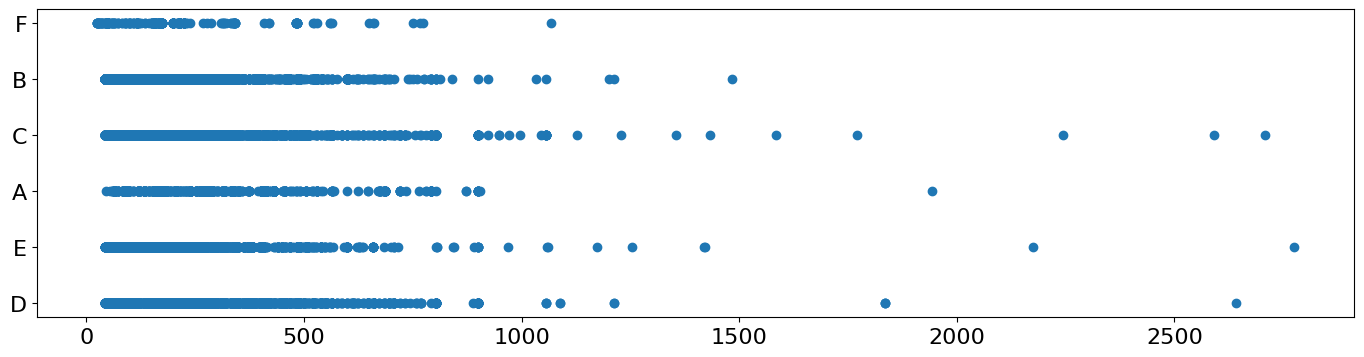

In [8]:
plotDataLengths(df)

In [9]:
del df
del lengths

In [10]:
df = pd.DataFrame(training_data)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [12]:
def getSequenceFromDataset(index):
  return training_data[index,valid_periods[index][0] : valid_periods[index][1]]

In [13]:
getSequenceFromDataset(0)

array([0.49166667, 0.52407407, 0.54444444, 0.46388889, 0.40648148,
       0.35462963, 0.31296296, 0.36666667, 0.38333333, 0.27962963,
       0.23796296, 0.25740741, 0.47962963, 0.43240741, 0.53518519,
       0.48055556, 0.37592593, 0.38611111, 0.32685185, 0.36666667,
       0.25555556, 0.23981481, 0.21111111, 0.26481481, 0.46851852,
       0.46944444, 0.41666667, 0.43981481, 0.36111111, 0.32592593,
       0.30740741, 0.34259259, 0.28611111, 0.2787037 , 0.18425926,
       0.21111111, 0.38518519, 0.375     , 0.44444444, 0.32962963,
       0.38981481, 0.29444444, 0.27037037, 0.33518519, 0.31666667,
       0.31481481, 0.28888889, 0.31203704, 0.39444444, 0.475     ,
       0.51666667, 0.47685185, 0.47777778, 0.37222222, 0.32685185,
       0.43888889, 0.35833333, 0.40648148, 0.36944444, 0.38981481,
       0.55462963, 0.53333333, 0.5537037 , 0.53518519, 0.48333333,
       0.50462963, 0.42777778, 0.4787037 , 0.46666667, 0.42962963,
       0.43888889, 0.41296296, 0.55833333, 0.52314815, 0.56944

# **GET ONE HOT CATEGORIES**


In [14]:
categories

array(['D', 'D', 'D', ..., 'F', 'F', 'F'], dtype='<U1')

In [15]:
np.unique(categories)

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1')

In [16]:
# Create a dictionary to map categories to numerical values
category_to_index = {category: index for index, category in enumerate(np.unique(categories))}
category_to_index

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [17]:
# Convert labels to numerical values using the dictionary
numerical_labels = [category_to_index[label] for label in categories]
numerical_labels[:15]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [18]:
one_hot_categories = tfk.utils.to_categorical(numerical_labels,len(np.unique(categories)))

In [19]:
one_hot_categories[-1]

array([0., 0., 0., 0., 0., 1.])

# **Some Plots**

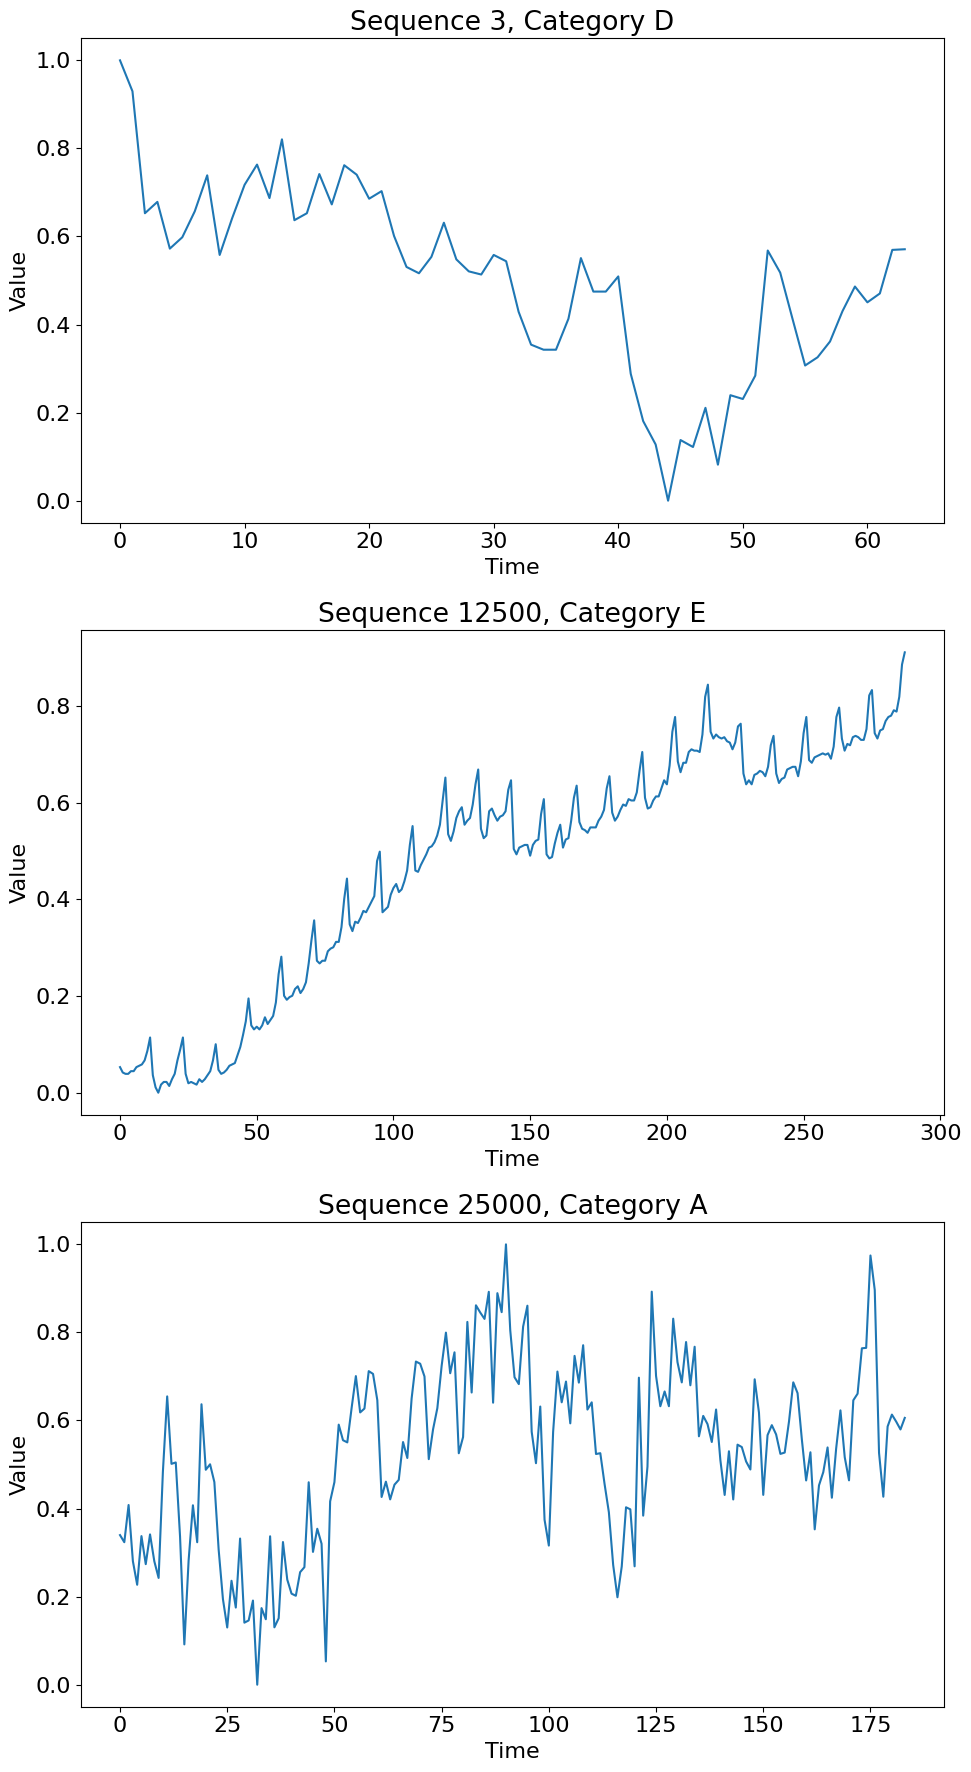

In [20]:
def inspect_dataset(indexes):
    num_plots = len(indexes)
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

    for i, index in enumerate(indexes):


        sequence = getSequenceFromDataset(index)  # Slice the sequence using iloc

        if num_plots > 1:
            ax = axs[i]
        else:
            ax = axs  # If only one plot, axs is a single axis, not an array

        ax.set_title(f"Sequence {index}, Category {categories[index]}")
        ax.plot(sequence)  # Plot the entire sequence
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")

    plt.tight_layout()
    plt.show()

# Call the function with the DataFrame and a list of indexes of the sequences you want to plot
inspect_dataset([3, 12500, 25000])  # Example: plotting sequences with indexes 3, 5, and 7


# **Normalize and Split the Dataset**

In [21]:
test_quota = TEST_QUOTA
test_quota

0.2

In [22]:
from sklearn.model_selection import train_test_split

# Creating indices for splitting
indices = np.arange(len(training_data))

# Splitting indices into train and test indices
train_indices, test_indices = train_test_split(indices, test_size=test_quota, stratify=categories, random_state=seed)

# Extracting data based on the split indices
train_data = training_data[train_indices]
test_data = training_data[test_indices]
train_categories = categories[train_indices]
test_categories = categories[test_indices]
valid_periods_train = valid_periods[train_indices]
valid_periods_test = valid_periods[test_indices]

In [23]:
train_data.shape

(38400, 2776)

In [24]:
test_data.shape

(9600, 2776)

In [25]:
training_data.shape

(48000, 2776)

In [26]:
def getTrainSequenceFromDataset(index):
  return train_data[index,valid_periods_train[index][0] : valid_periods_train[index][1]]

def getTestSequenceFromDataset(index):
  return test_data[index,valid_periods_test[index][0] : valid_periods_test[index][1]]


In [27]:
getTrainSequenceFromDataset(0).shape[0]

512

In [28]:
getTestSequenceFromDataset(0).shape[0]

267

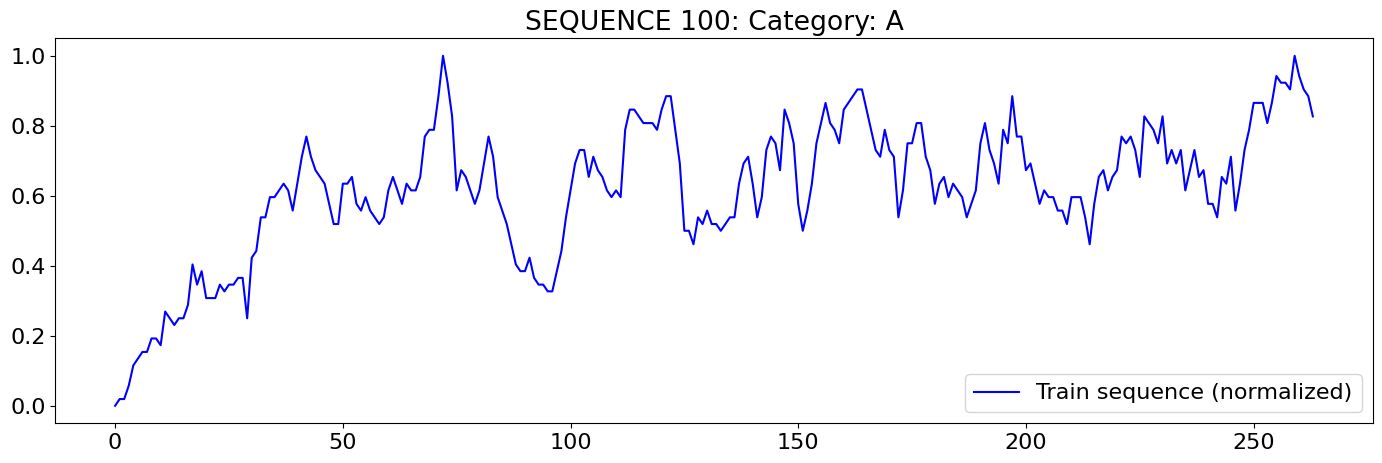

In [29]:
import matplotlib.pyplot as plt
index_to_plot = 100

# Assuming X_train_raw and X_test_raw are NumPy arrays
plt.figure(figsize=(17, 5))

# Plot X_train_raw in blue color
plt.plot(getTrainSequenceFromDataset(index_to_plot), label='Train sequence (normalized)', color='blue')


plt.title(f'SEQUENCE {index_to_plot}: Category: {train_categories[index_to_plot]}')
plt.legend()
plt.show()

# **Prepare the Data**


In [30]:
window = WINDOW_SIZE
stride = STRIDE_SIZE

In [31]:
future = train_data[:,-window:]

print(f"future has {future[123].shape} sequences")

future has (200,) sequences


In [32]:
future = np.expand_dims(future, axis=0)
future.shape

(1, 38400, 200)

In [33]:
def build_sequences(train=True, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []

    maxIndex = train_data.shape[0] if train==True else test_data.shape[0]

    for index in range(maxIndex):

      if train == True:
        sequence = getTrainSequenceFromDataset(index)
        temp_sequence = getTrainSequenceFromDataset(index).copy()
      else:
        sequence = getTestSequenceFromDataset(index)
        temp_sequence = getTestSequenceFromDataset(index).copy()

      temp_label = sequence.copy()

      padding_check = len(sequence)%window

      if(padding_check != 0):
        # Compute padding length
        padding_len = window - len(sequence)%window
        padding = np.zeros((padding_len), dtype='float32')
        temp_sequence = np.concatenate((padding,sequence))
        padding = np.zeros((padding_len), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_sequence) % window == 0

      for idx in np.arange(0,len(temp_sequence)-window-telescope,stride):
        dataset.append(temp_sequence[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

      del sequence
      del temp_sequence
      del temp_label

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [34]:
telescope = TELESCOPE_SIZE

# **Data Augmentation**

In [35]:
import random

def jitter(sequence, noise_level=0.01):
    noise = np.random.normal(loc=0, scale=noise_level, size=sequence.shape)
    return sequence + noise

def scale(sequence, scaling_factor=2.0):
    return sequence * scaling_factor

def time_warp(sequence, stretch_factor=1.5):
    sequence_length = len(sequence)
    warped_length = int(sequence_length * stretch_factor)
    warped_sequence = np.interp(np.linspace(0, sequence_length, num=warped_length, endpoint=False),
                                np.arange(sequence_length), sequence)
    if warped_length < 200:
        return np.pad(warped_sequence, (200 - len(sequence), 0), 'constant')
    else:
        return warped_sequence[:200]

def flip(sequence):
    return np.flip(sequence)

def random_augmentation(sequence):
    # Ensure sequence is of length 200
    if len(sequence) < 200:
        sequence = np.pad(sequence, (200 - len(sequence), 0), 'constant')

    # Choose a random augmentation and apply it with random parameters within specified ranges
    augmentation_functions = {
        'jitter': lambda seq: jitter(seq, noise_level=random.uniform(0.01, 0.05)),
        'scale': lambda seq: scale(seq, scaling_factor=random.uniform(0.8, 1.2)),
        'time_warp': lambda seq: time_warp(seq, stretch_factor=random.uniform(0.7, 1.5)),
        'flip': lambda seq: flip(seq)
    }

    augmented_sequence = random.choice(list(augmentation_functions.values()))(sequence)

    # Ensure the augmented sequence is of length 200
    if len(augmented_sequence) < 200:
        augmented_sequence = np.pad(augmented_sequence, (200 - len(sequence), 0), 'constant')

    return augmented_sequence

# **FORECAST**

In [36]:
direct_telescope = telescope

In [37]:
stride

10

In [38]:
def build_CONV_LSTM_model(input_shape, output_shape):

    # 2 bidirectional LSTM and one dense

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    bilstm1 = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    dropout1 = tfkl.Dropout(.3, seed=seed)(bilstm1)
    bilstm2 = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=False))(dropout1)
    dropout2 = tfkl.Dropout(.3, seed=seed)(bilstm2)

    dense1 = tfkl.Dense(512)(dropout2)

    dense2 = tfkl.Dense(output_shape[-1]*output_shape[-2], kernel_initializer = tfk.initializers.GlorotUniform(seed))(dense1)
    leaky_relu_layer = tfkl.LeakyReLU()(dense2)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(leaky_relu_layer)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.AdamW(), metrics=['mae'])

    # Return the model
    return model




# **Make it Autoregressive**

In [39]:
autoregressive_telescope = 3
assert autoregressive_telescope < telescope

In [40]:
epochs = EPOCHS
batch_size = BATCH_SIZE

In [41]:
X_train, y_train = build_sequences(True,window, stride, autoregressive_telescope)
#X_test, y_test = build_sequences(False,window, stride, autoregressive_telescope)

In [42]:
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

In [43]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 200, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 512)       │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3, 1)           │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,367,493 (9.03 MB)

 Trainable params: 2,367,493 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

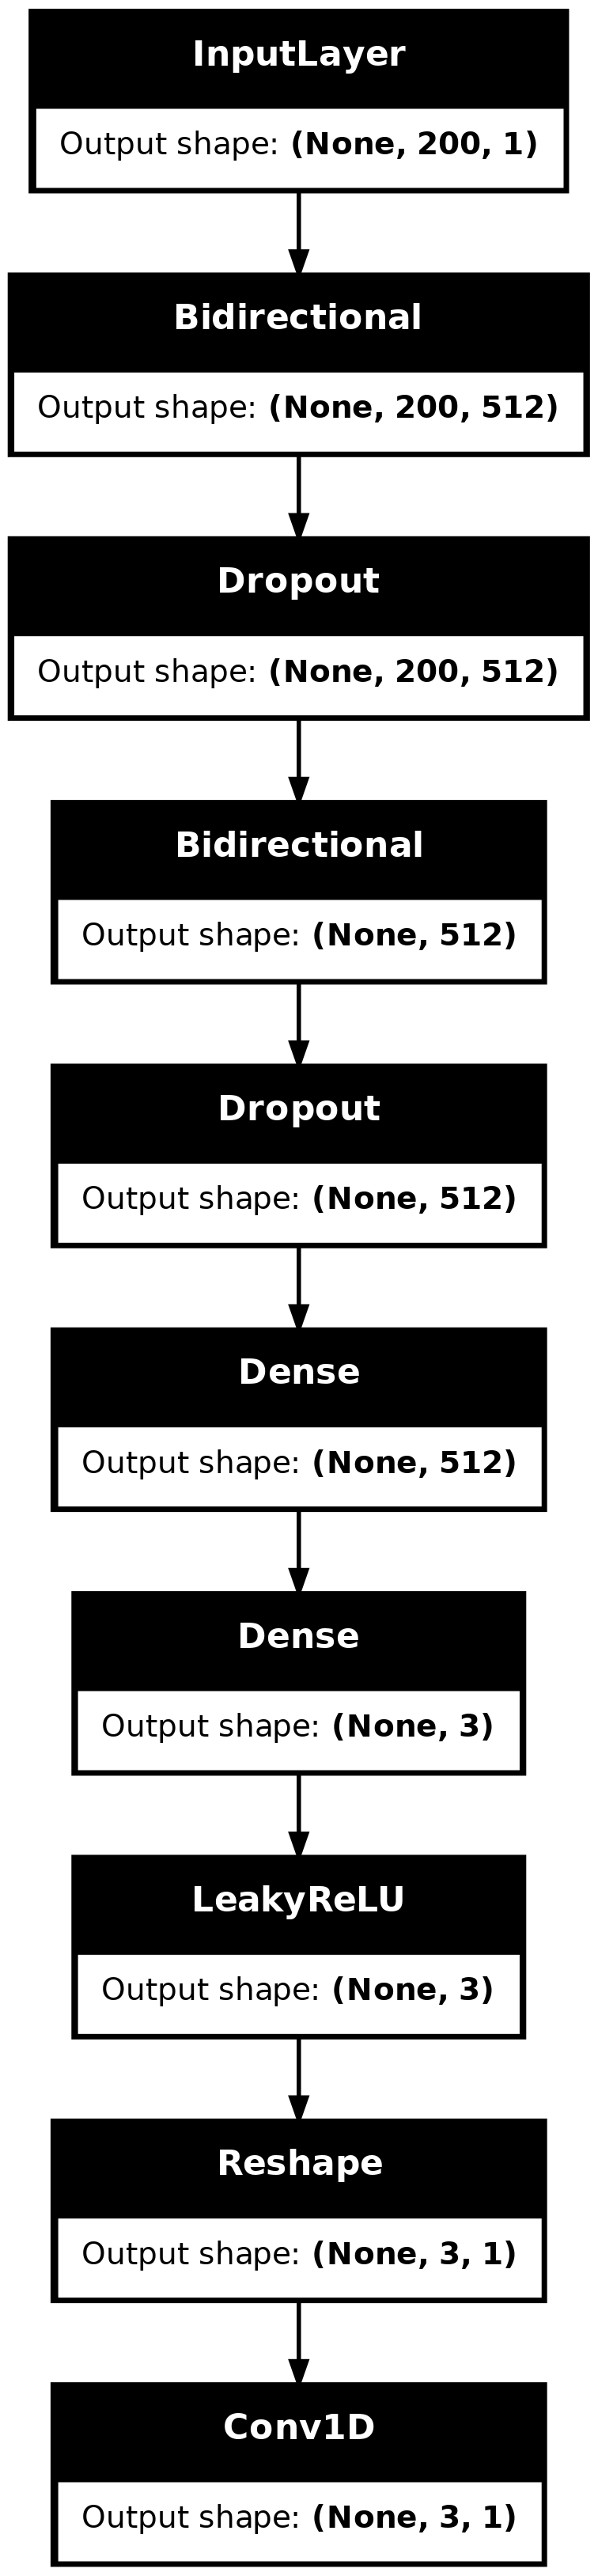

In [44]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [45]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 250,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/250
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - loss: 0.0150 - mae: 0.0739 - val_loss: 0.0058 - val_mae: 0.0479 - learning_rate: 0.0010
Epoch 2/250
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 89s 58ms/step - loss: 0.0061 - mae: 0.0506 - val_loss: 0.0055 - val_mae: 0.0460 - learning_rate: 0.0010
Epoch 3/250
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 88s 58ms/step - loss: 0.0055 - mae: 0.0481 - val_loss: 0.0048 - val_mae: 0.0434 - learning_rate: 0.0010
Epoch 4/250
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 89s 59ms/step - loss: 0.0049 - mae: 0.0452 - val_loss: 0.0046 - val_mae: 0.0414 - learning_rate: 0.0010
Epoch 5/250
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 89s 58ms/step - loss: 0.0048 - mae: 0.0446 - val_loss: 0.0044 - val_mae: 0.0407 - learning_rate: 0.0010
Epoch 6/250
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 89s 59ms/step - loss: 0.0046 - mae: 0.0436 - val_loss: 0.0042 - val_mae: 0.0392 - learning_rate: 0.0010
Epoch 7/250
1514/1514 ━━━━━━━━━━━━━━━━━━━━ 91s 60ms/step - loss: 0.0045 - mae: 0.0428 - val_loss: 0.0041 - val_mae: 0.

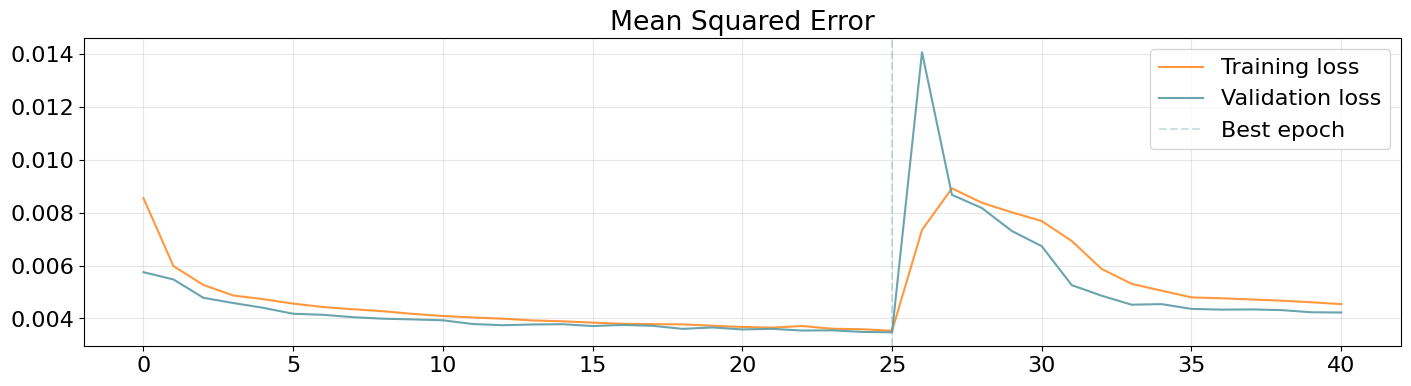

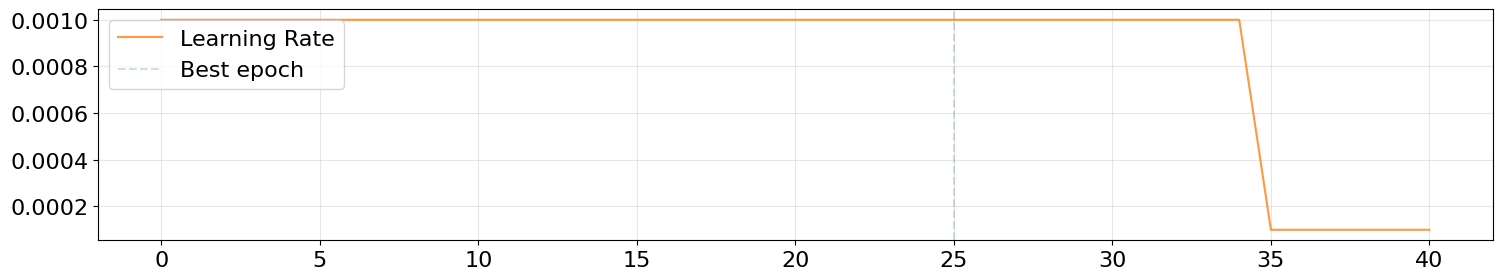

In [46]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['learning_rate'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [47]:
model.save(MODEL_NAME+".keras")

In [48]:
del model

In [ ]:
model = tfk.models.load_model(MODEL_NAME+".keras")

In [57]:
X_test_reg, y_test_reg = build_sequences(False,window, stride, telescope)
X_test_reg.shape, y_test_reg.shape

((103699, 200), (103699, 18))

In [58]:
# Autoregressive Forecasting
X_test_reg = np.expand_dims(X_test_reg, axis=-1)

reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,telescope,autoregressive_telescope):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,autoregressive_telescope:],pred_temp), axis=1)

In [59]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (103699, 18, 1)
Mean Squared Error: 0.01070618350058794
Mean Absolute Error: 0.07098537683486938
